# System ID with Neural ODEs in NeuroMANCER: LinearSimpleSingleZone



In [1]:
import numpy as np
import sklearn.metrics as metrics
from matplotlib import pyplot as plt

import torch
from torch.utils.data import DataLoader

from neuromancer import psl, blocks
from neuromancer.dynamics import integrators
from neuromancer.modules.activations import SoftExponential
from neuromancer.dataset import DictDataset
from neuromancer.system import Node, System
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.trainer import Trainer
from tqdm.auto import tqdm

from neuromancer.psl import plot

/Users/shap825/anaconda3/envs/neuromancer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(0)

## Generate trajectories

In [3]:
system = psl.systems["LinearSimpleSingleZone"](backend="torch")

/Users/shap825/VSCodeProjects/neuromancer/src/neuromancer/psl/base.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  parameters = {k: self.B.grad(self.B.cast(v, dtype=self.B.core.float32), requires_grad)
/Users/shap825/VSCodeProjects/neuromancer/src/neuromancer/psl/base.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.B.cast(method_output, dtype=self.B.core.float32)


In [4]:
raw = system.simulate(nsim=1000)

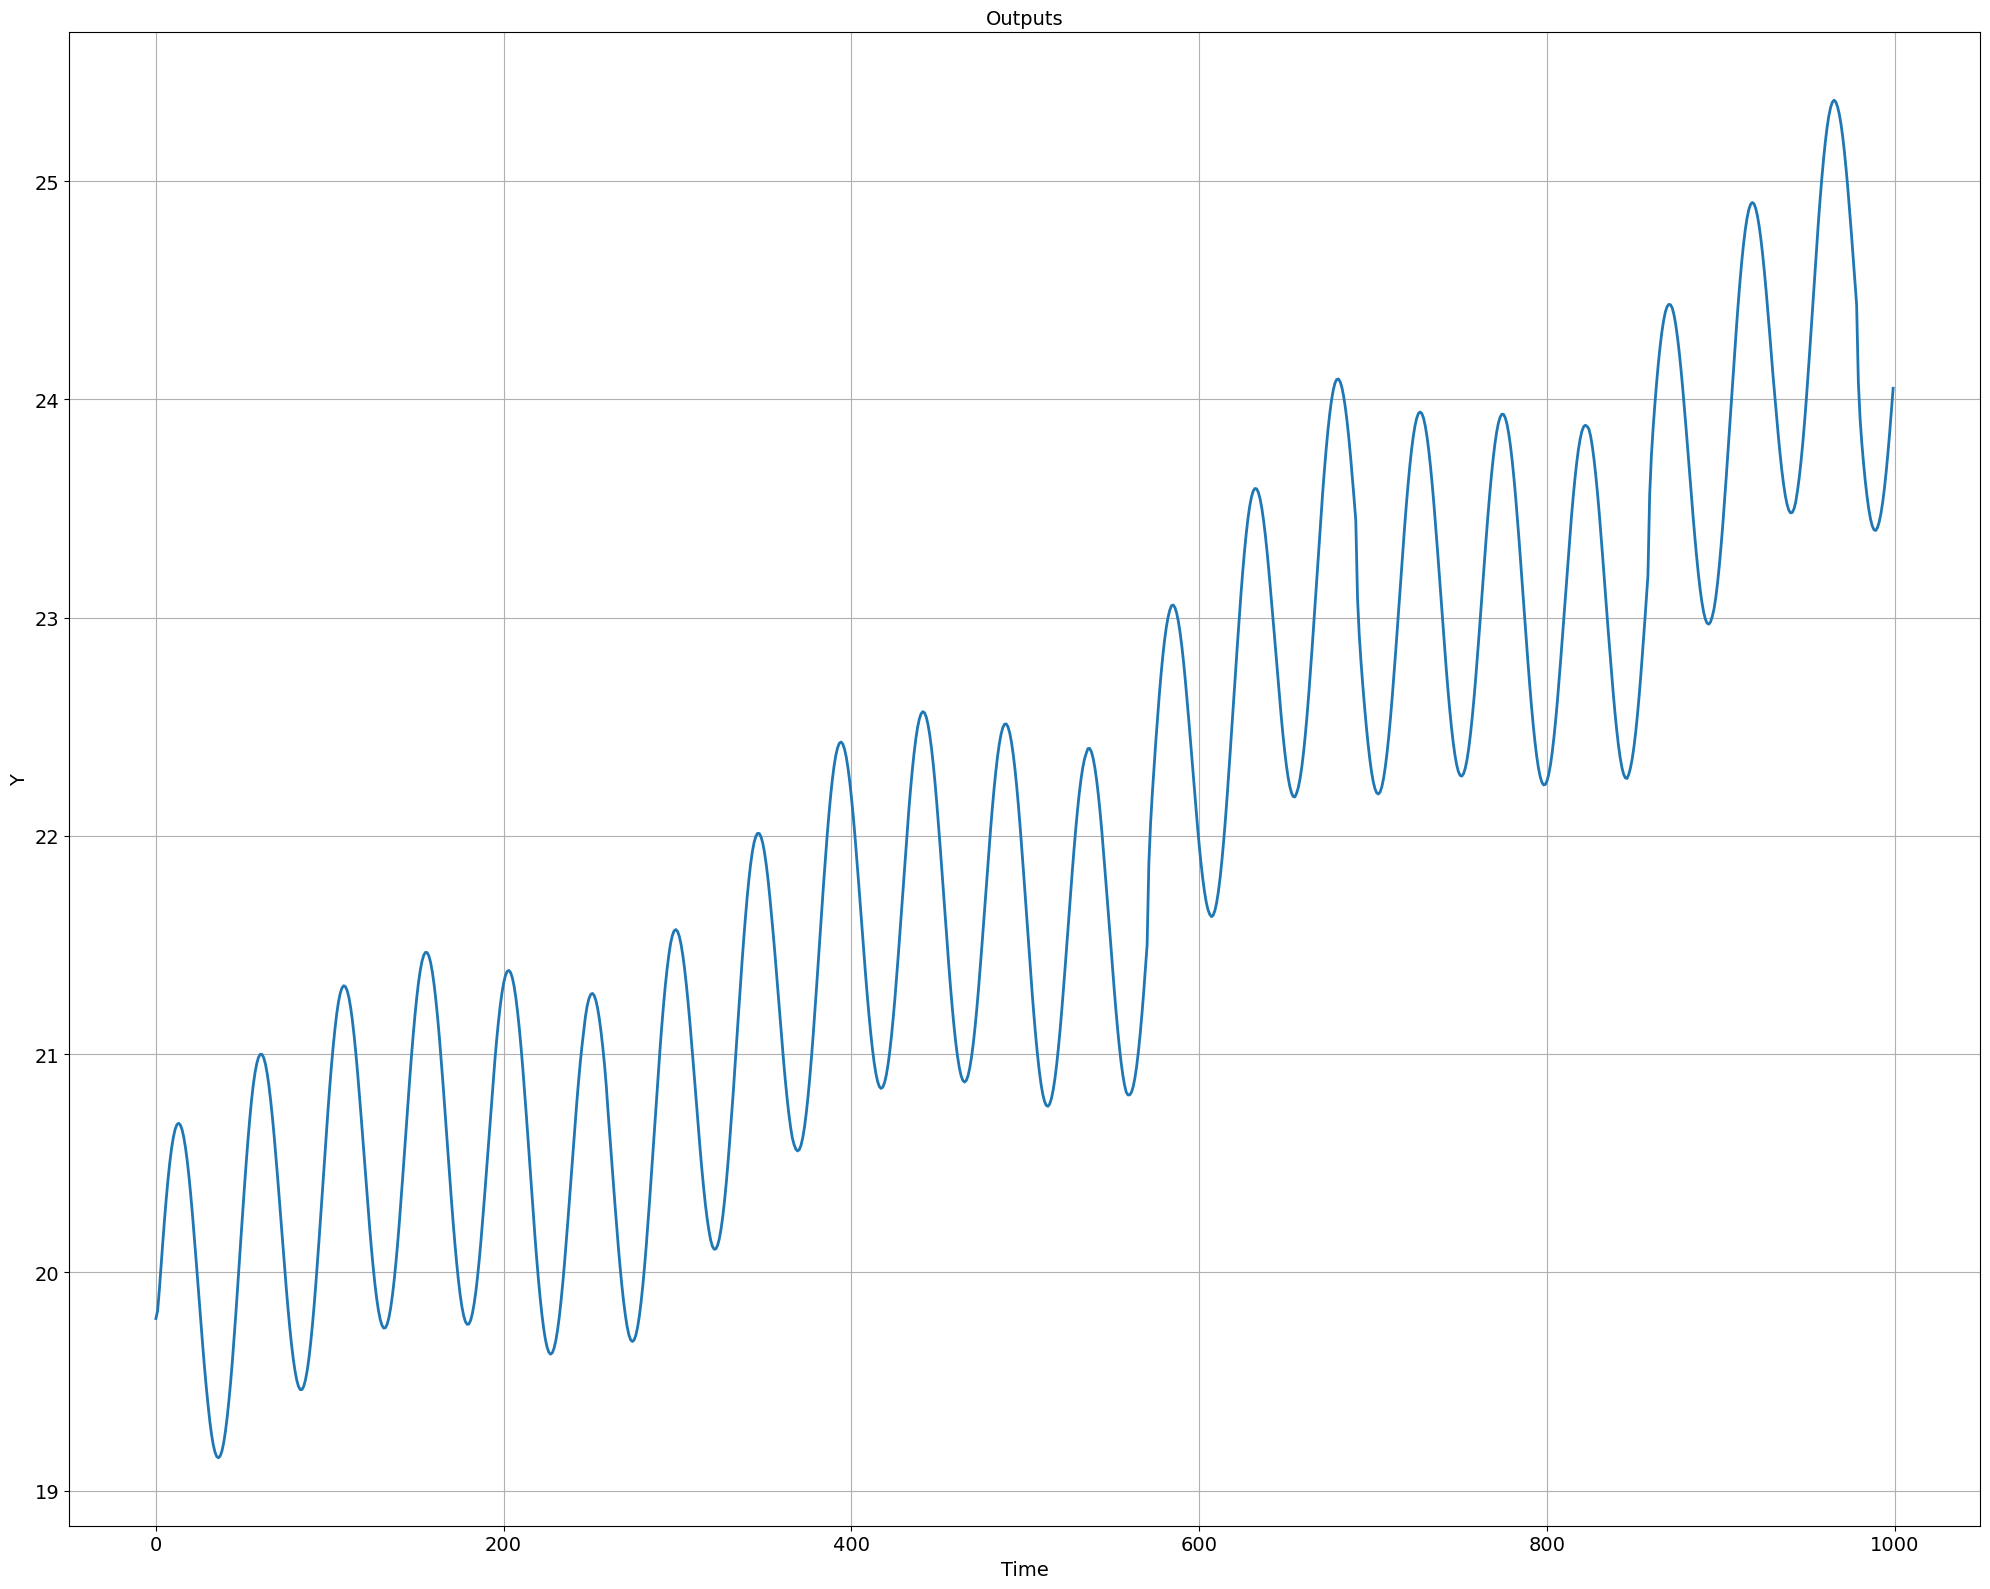

In [5]:
plot.pltOL(Y=raw["Y"])

# Generate datasets

NOTE: get_data always uses the same x0 - seems potentially problematic but when I use sys.get_x0() performance is much worse for some reason?

In [6]:
def get_data(sys, nsim, nsteps, signal=None, normalize=True):

    ylist, ulist, dlist= [], [], []
    for i in tqdm(range(nsim), desc=f"Getting data..."):
        x0 = sys.x0
        given_U = torch.tensor(sys.get_U(nsteps + 1, signal=signal))
        sim = sys.simulate(nsim=nsteps, x0=x0, U=given_U)
        Y = torch.tensor(sys.normalize(sim['Y'], key='Y'), dtype=torch.float32)
        U = torch.tensor(sys.normalize(sim['U'], key='U'), dtype=torch.float32)
        D = torch.tensor(sys.normalize(sim['D'], key='D'), dtype=torch.float32)

        given_U = sys.normalize(given_U, key='U')

        ylist.append(Y)
        ulist.append(given_U[:-1, :])
        # ulist.append(U)
        dlist.append(D)

    Y, U, D = torch.stack(ylist), torch.stack(ulist), torch.stack(dlist)
    ny, nu, nd = Y.shape[-1], U.shape[-1], D.shape[-1]

    return {'Y': Y, 'U': U, 'D': D, 'yn': Y[:, 0:1, :]}




In [7]:
def get_dataloader(data, batch_size, name="train", shuffle=True):
    dataset = DictDataset(data, name=name)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=dataset.collate_fn,
        shuffle=shuffle,
    )

In [8]:
nsim = 1000
nsteps = 128

train_data = get_data(system, nsim, nsteps)
dev_data = get_data(system, round(nsim*0.2), nsteps)
test_data = get_data(system, 1, nsim)

Getting data...:   0%|          | 0/1000 [00:00<?, ?it/s]

/var/folders/lr/b4pfyyk14djbmtbn7jvyd6gc0000gn/T/ipykernel_32273/362387094.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  given_U = torch.tensor(sys.get_U(nsteps + 1, signal=signal))
/var/folders/lr/b4pfyyk14djbmtbn7jvyd6gc0000gn/T/ipykernel_32273/362387094.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(sys.normalize(sim['Y'], key='Y'), dtype=torch.float32)
/var/folders/lr/b4pfyyk14djbmtbn7jvyd6gc0000gn/T/ipykernel_32273/362387094.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  U = torch.tensor(sys.normalize

In [9]:
train_loader = get_dataloader(train_data, batch_size=128, name="train")
dev_loader = get_dataloader(dev_data, batch_size=128, name="dev")

In [10]:
system.ny, system.nu, system.nd

(1, 1, 1)

In [11]:
dy = blocks.MLP(
    system.ny + system.nu + system.nd,
    system.ny,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=SoftExponential,
    hsizes = [64, 64, 64],
)

In [12]:
dyRK4 = integrators.RK4(dy, h=system.ts)

In [13]:
dynamics_model = System([Node(dyRK4, ["yn", "U", "D"], ["yn"])], nstep_key="Y")

In [14]:
y = variable("Y")
yhat = variable("yn")[:,:-1]

yFD = (y[:, 1:, :] - y[:,:-1,:])
yhatFD = (yhat[:, 1:, :] - yhat[:,:-1,:])

fd_loss = (yFD == yhatFD)^2
fd_loss.name = "FD_loss"

reference_loss = (yhat == y)^2
reference_loss.name = "ref_loss"

In [15]:
objectives = [reference_loss, fd_loss]
constraints = []
loss = PenaltyLoss(objectives, constraints)
problem = Problem([dynamics_model], loss)

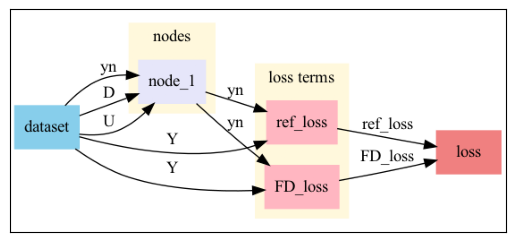

In [16]:
problem.show()

In [17]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=0.001)
logger = BasicLogger(
    args=None,
    savedir="test",
    verbosity=1,
    stdout=["dev_loss", "train_loss"],
)

None


In [18]:
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    dev_loader,
    optimizer,
    logger,
    patience=10,
    warmup=10,
    epochs=100,
    eval_metric="dev_loss",
    train_metric="train_loss"
)

Number of parameters: 8644


In [19]:
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0	train_loss: 0.11436	dev_loss: 0.10927	eltime:  1.00440
epoch: 1	train_loss: 0.10792	dev_loss: 0.11629	eltime:  1.99388
epoch: 2	train_loss: 0.10421	dev_loss: 0.10851	eltime:  2.99403
epoch: 3	train_loss: 0.10576	dev_loss: 0.10484	eltime:  3.98365
epoch: 4	train_loss: 0.10290	dev_loss: 0.10516	eltime:  4.95790
epoch: 5	train_loss: 0.10200	dev_loss: 0.10243	eltime:  5.93566
epoch: 6	train_loss: 0.10112	dev_loss: 0.10222	eltime:  6.91961
epoch: 7	train_loss: 0.09719	dev_loss: 0.09567	eltime:  7.89282
epoch: 8	train_loss: 0.09626	dev_loss: 0.09763	eltime:  8.87317
epoch: 9	train_loss: 0.09214	dev_loss: 0.09463	eltime:  9.87829
epoch: 10	train_loss: 0.09072	dev_loss: 0.09309	eltime:  10.85946
epoch: 11	train_loss: 0.08882	dev_loss: 0.09016	eltime:  11.82516
epoch: 12	train_loss: 0.08587	dev_loss: 0.08669	eltime:  12.83427
epoch: 13	train_loss: 0.07953	dev_loss: 0.07934	eltime:  13.86462
epoch: 14	train_loss: 0.07012	dev_loss: 0.07029	eltime:  14.86427
epoch: 15	train_loss: 0.05793	

<All keys matched successfully>

In [20]:
test_data = get_data(system, 1, 1000)

Getting data...:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/lr/b4pfyyk14djbmtbn7jvyd6gc0000gn/T/ipykernel_32273/362387094.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  given_U = torch.tensor(sys.get_U(nsteps + 1, signal=signal))
/Users/shap825/VSCodeProjects/neuromancer/src/neuromancer/psl/base.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.B.cast(method_output, dtype=self.B.core.float32)
/var/folders/lr/b4pfyyk14djbmtbn7jvyd6gc0000gn/T/ipykernel_32273/362387094.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTens

In [21]:
with torch.no_grad():
    test_outputs=dynamics_model(test_data)

In [22]:
for key in test_outputs:
    if key == 'yn':
        test_outputs['yn'] = system.denormalize(test_outputs['yn'], key='Y')
    else:
        test_outputs[key] = system.denormalize(test_outputs[key], key=key)


In [23]:
pred_traj = test_outputs["yn"][:,:-1].detach().numpy()
true_traj = test_outputs["Y"].detach().numpy()

pred_traj = pred_traj.reshape(-1,system.ny)
true_traj = true_traj.reshape(-1,system.ny)

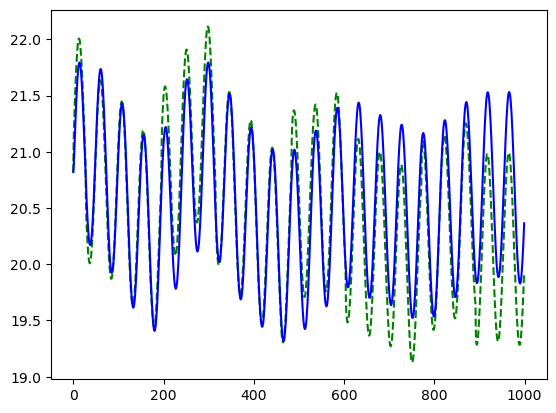

In [24]:
fig, ax = plt.subplots()
ax.plot(true_traj, 'g--')
ax.plot(pred_traj, 'b')

In [25]:
print(metrics.mean_absolute_error(true_traj, pred_traj))
print(metrics.mean_squared_error(true_traj, pred_traj))
print(metrics.r2_score(true_traj, pred_traj))

0.22776528
0.07926374
0.8418143568186736
